# EDA + Baselines 

Den här notebooken kombinerar  **EDA** med **baslinemodeller**.

In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

DATA_PATH = "C:\EC_skola\Projekt_i_DS\svk_forescast\data\processed\dataset\hourly_eda.csv"
TIMESTAMP_COL = "time_utc"
TARGET_COL    = "value"
AREA_COL      = "area"
WEATHER_COLS  = ["temp_c", "wind_ms", "precip_mm"]

plt.rcParams["figure.figsize"] = (10, 4)


## Läs in och förbered data

In [2]:

in_path = Path(DATA_PATH)
if in_path.suffix.lower() == ".parquet":
    df_raw = pd.read_parquet(in_path)
else:
    df_raw = pd.read_csv(in_path, sep=";")
    if df_raw.shape[1] == 1:
        df_raw = pd.read_csv(in_path)

print("Rådata shape:", df_raw.shape)
print("Kolumner:", list(df_raw.columns))
df_raw.head(3)


Rådata shape: (87552, 12)
Kolumner: ['area', 'time_utc', 'value', 'temp_c', 'wind_ms', 'precip_mm', 'hour', 'dow', 'month', 'is_weekend', 'is_dst', 'date']


,area,time_utc,value,temp_c,wind_ms,precip_mm,hour,dow,month,is_weekend,is_dst,date
0,SE1,2023-01-01 00:00:00+00:00,1277.760665,-2.979167,5.647917,0.0,1,6,1,True,False,2023-01-01
1,SE1,2023-01-01 01:00:00+00:00,1283.283639,-3.332552,5.469184,0.0,2,6,1,True,False,2023-01-01
2,SE1,2023-01-01 02:00:00+00:00,1284.192506,-3.685938,5.290451,0.0,3,6,1,True,False,2023-01-01


## Tidsindex (UTC = Europe/Stockholm) och timraster

In [3]:

def ensure_dt_index(df, tcol, tz="Europe/Stockholm"):
    x = df.copy()
    if tcol not in x.columns:
        raise ValueError(f"Saknar tidskolumn '{tcol}'. Tillgängligt: {list(x.columns)}")
    t = pd.to_datetime(x[tcol], errors="coerce", utc=True).dt.tz_convert(tz)
    x = x.dropna(subset=[tcol]).copy()
    x.index = t
    x = x.sort_index()
    return x

df = ensure_dt_index(df_raw, TIMESTAMP_COL)
before = df.shape[0]
df = df[(df.index.minute == 0) & (df.index.second == 0)]
after = df.shape[0]
print(f"Filtrerade bort {before - after} rader som inte låg på hel timme.")
print("Shape:", df.shape)
df[[AREA_COL, TARGET_COL]].head(3)


Filtrerade bort 36 rader som inte låg på hel timme.
Shape: (87516, 12)


,area,value
time_utc,,
2023-01-01 01:00:00+01:00,SE1,1277.760665
2023-01-01 01:00:00+01:00,SE3,8788.012122
2023-01-01 01:00:00+01:00,SE4,1891.830782


## Snabb datakvalitet 

In [8]:

key_cols = [c for c in [TARGET_COL] + WEATHER_COLS if c in df.columns]

print("Andel saknade värden (topp 10):")
display(df.isna().mean().sort_values(ascending=False).head(10))

print("\nBeskrivande statistik (target + väder):")
display(df[key_cols].describe(percentiles=[.01,.05,.5,.95,.99]).T)


Andel saknade värden (topp 10):


wind_ms       0.003554
precip_mm     0.000263
area          0.000000
time_utc      0.000000
value         0.000000
temp_c        0.000000
hour          0.000000
dow           0.000000
month         0.000000
is_weekend    0.000000
dtype: float64


Beskrivande statistik (target + väder):


,count,mean,std,min,1%,5%,50%,95%,99%,max
value,87516.0,3671.736929,3404.728696,777.370500,954.076987,1053.349948,2020.286637,11159.78705,12865.701755,16136.459680
temp_c,87516.0,5.656865,9.067751,-36.039583,-17.416562,-9.859881,5.520341,18.23125,20.279236,23.540278
wind_ms,87205.0,3.349727,1.400574,0.041667,0.892375,1.445652,3.154514,5.96875,7.545792,10.925996
precip_mm,87493.0,0.002705,0.039582,0.000000,0.000000,0.000000,0.000000,0.00000,0.037500,2.279167


## Säsongsmönster (månad, veckodag och timme)

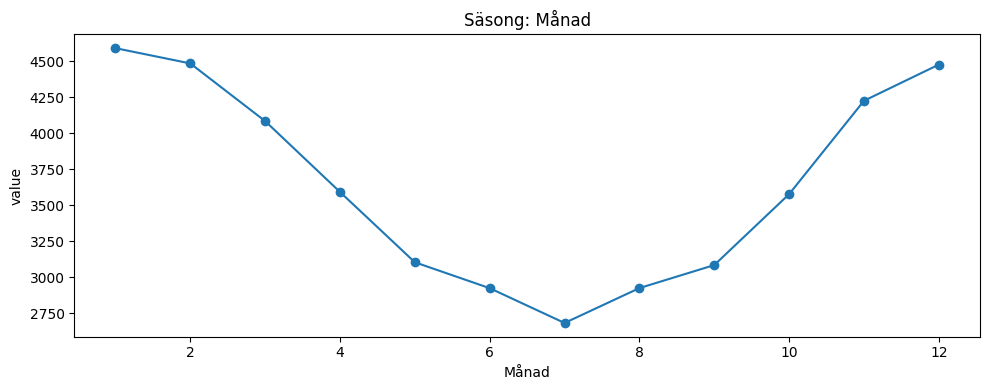

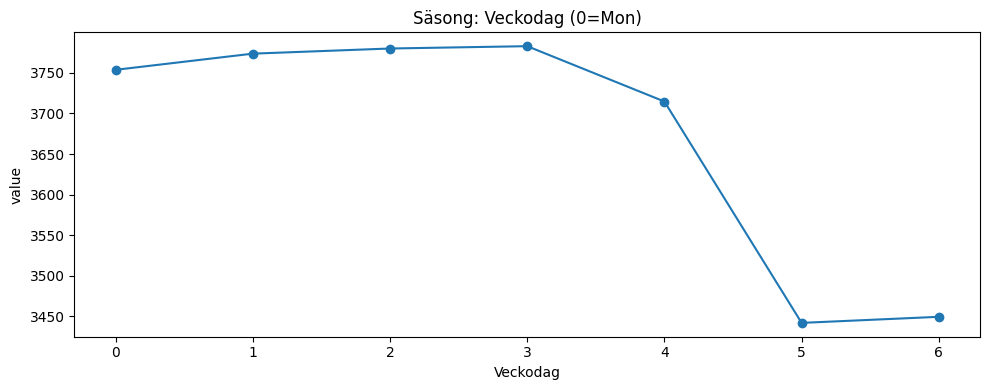

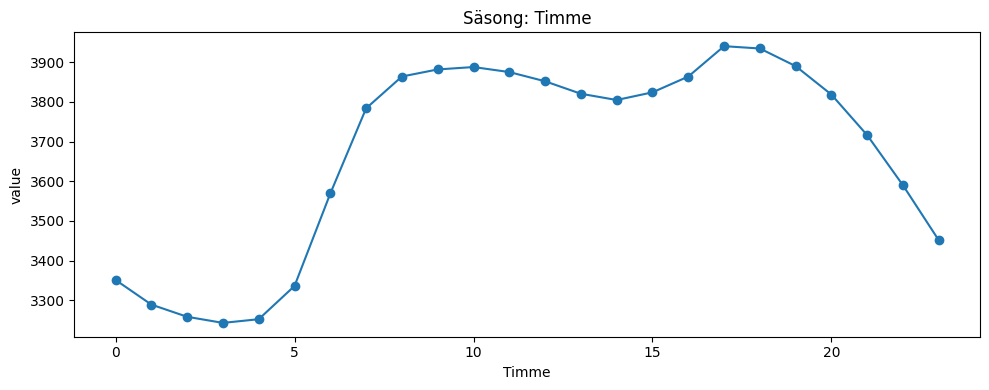

area,SE1,SE2,SE3,SE4
month,,,,
1,1535.301499,2201.531734,11514.514554,3109.457993
2,1504.972353,2130.338930,11278.606429,3022.388761
3,1400.072320,1917.203419,10285.182546,2731.610089
4,1246.892245,1693.815908,9061.425598,2362.825729
5,1086.391244,1467.430490,7797.097889,2061.819925


area,SE1,SE2,SE3,SE4
dow,,,,
0,1279.245891,1762.640887,9446.690445,2526.179856
1,1286.071411,1762.148868,9489.050576,2557.129477
2,1281.848621,1773.653756,9506.797852,2557.416922
3,1288.323333,1778.476927,9504.744043,2559.711531
4,1284.213804,1766.991862,9311.353169,2495.936184


area,SE1,SE2,SE3,SE4
hour,,,,
0,1220.511610,1619.628001,8373.441353,2191.587311
1,1209.349180,1594.817278,8208.862003,2143.781055
2,1205.696726,1583.082745,8122.808016,2122.333684
3,1205.006682,1580.138474,8073.032867,2114.237234
4,1216.524795,1592.285773,8080.825297,2119.898347


In [9]:

base = df.dropna(subset=[TARGET_COL]).copy()
base["month"] = base.index.month
base["dow"]   = base.index.dayofweek
base["hour"]  = base.index.hour

def season_agg(tbl, by, label):
    if AREA_COL in tbl.columns:
        res = tbl.groupby([AREA_COL, by])[TARGET_COL].mean().unstack(0)
    else:
        res = tbl.groupby(by)[TARGET_COL].mean().to_frame("ALL")
    res.index.name = label
    return res

by_month = season_agg(base, "month", "month")
by_dow   = season_agg(base, "dow",   "dow")
by_hour  = season_agg(base, "hour",  "hour")

by_month.mean(axis=1).plot(marker="o"); plt.title("Säsong: Månad"); plt.xlabel("Månad"); plt.ylabel(TARGET_COL); plt.tight_layout(); plt.show()
by_dow.mean(axis=1).plot(marker="o");   plt.title("Säsong: Veckodag (0=Mon)"); plt.xlabel("Veckodag"); plt.ylabel(TARGET_COL); plt.tight_layout(); plt.show()
by_hour.mean(axis=1).plot(marker="o");  plt.title("Säsong: Timme"); plt.xlabel("Timme"); plt.ylabel(TARGET_COL); plt.tight_layout(); plt.show()

display(by_month.head()); display(by_dow.head()); display(by_hour.head())


## Korrelationer – totalt och per område

In [10]:

features = [c for c in WEATHER_COLS if c in df.columns]

def corr_row(tbl, target, feats):
    out = {}
    for f in feats:
        s = tbl[[target, f]].dropna()
        if len(s) >= 3 and s[f].std(ddof=0) > 0:
            out[f"pearson_{f}"]  = s[target].corr(s[f], method="pearson")
            out[f"spearman_{f}"] = s[target].corr(s[f], method="spearman")
        else:
            out[f"pearson_{f}"]  = np.nan
            out[f"spearman_{f}"] = np.nan
    return pd.Series(out)

corr_all = corr_row(df, TARGET_COL, features).to_frame(name="ALL")

corr_area = None
if AREA_COL in df.columns:
    frames = []
    for a, g in df.groupby(AREA_COL):
        frames.append(corr_row(g, TARGET_COL, features).rename(a))
    corr_area = pd.concat(frames, axis=1) if frames else None

corr_df = corr_all.join(corr_area) if corr_area is not None else corr_all
out_dir = Path("outputs/eda_final"); out_dir.mkdir(parents=True, exist_ok=True)
corr_df.to_csv(out_dir / "correlations_overall_per_area.csv")
display(corr_df)


,ALL,SE1,SE2,SE3,SE4
pearson_temp_c,-0.042777,-0.897413,-0.873544,-0.851318,-0.814276
spearman_temp_c,-0.125802,-0.898034,-0.889050,-0.858380,-0.818006
pearson_wind_ms,0.143466,-0.178102,0.029791,0.092670,0.095862
spearman_wind_ms,0.145641,-0.184851,0.031271,0.113670,0.117640
pearson_precip_mm,-0.007492,-0.049361,NaN,-0.052776,-0.047499
spearman_precip_mm,-0.011974,-0.044302,NaN,-0.066831,-0.061952


## Korrelation per månad och säsong

C:\Users\gisse\AppData\Local\Temp\ipykernel_26772\3519411092.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby(by).apply(lambda g: corr_row(g, TARGET_COL, features))
C:\Users\gisse\AppData\Local\Temp\ipykernel_26772\3519411092.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby(by).apply(lambda g: corr_row(g, TARGET_COL, features))


,pearson_temp_c,spearman_temp_c,pearson_wind_ms,spearman_wind_ms,pearson_precip_mm,spearman_precip_mm
month,,,,,,
1,0.197054,0.325639,0.189691,0.225255,-0.007039,-0.025081
2,0.207237,0.351640,0.052483,0.063483,0.003235,-0.020256
3,0.268101,0.444749,0.218523,0.191628,-0.008548,-0.036217
4,0.212489,0.412670,0.228482,0.248658,-0.006948,-0.003402
5,0.214456,0.295451,0.076659,0.093471,0.000686,-0.023398
6,0.262522,0.308759,0.046964,0.067823,0.005486,-0.037323
7,0.235708,0.306663,0.088318,0.120884,-0.017182,-0.035777
8,0.282727,0.445901,0.068420,0.015735,-0.014664,-0.042445
9,0.209316,0.360765,0.001017,-0.066435,-0.010170,-0.046884


,pearson_temp_c,spearman_temp_c,pearson_wind_ms,spearman_wind_ms,pearson_precip_mm,spearman_precip_mm
season,,,,,,
Winter,0.194254,0.345105,0.103016,0.137079,-0.001181,-0.021313
Spring,0.090216,0.112908,0.179158,0.168296,-0.004550,-0.011261
Summer,0.236553,0.301436,0.066185,0.070794,-0.009413,-0.037746
Autumn,0.046239,0.034271,0.178901,0.146898,-0.008765,-0.020931


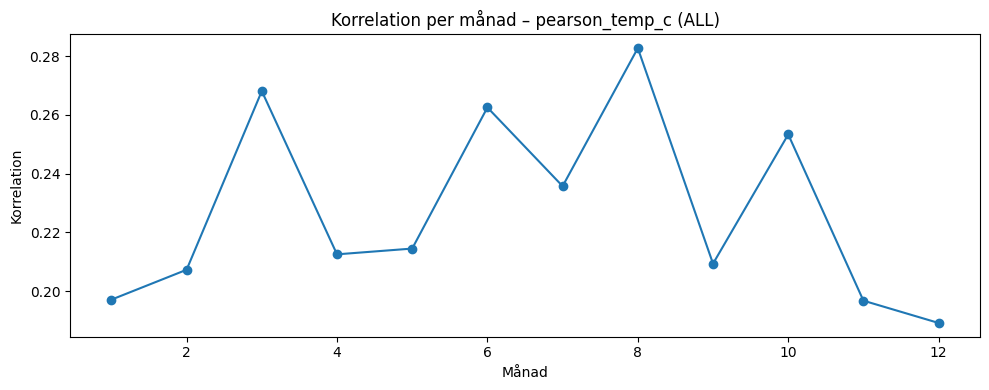

In [11]:
import pandas as pd
from packaging.version import parse as V

# välj bara kolumner vi behöver innan groupby (version-agnostiskt)
cols_needed = [TARGET_COL, *features]

def agg_corr_by(tmp: pd.DataFrame, by):
    gobj = tmp[cols_needed].groupby(by)
    if V(pd.__version__) >= V("2.2.0"):
        # nyare pandas: utnyttja include_groups=False
        return gobj.apply(lambda g: corr_row(g, TARGET_COL, features), include_groups=False)
    else:
        # äldre pandas: samma beteende uppnås genom att vi redan valt kolumner
        return gobj.apply(lambda g: corr_row(g, TARGET_COL, features))


season_map = {12:"Winter",1:"Winter",2:"Winter", 3:"Spring",4:"Spring",5:"Spring",
              6:"Summer",7:"Summer",8:"Summer", 9:"Autumn",10:"Autumn",11:"Autumn"}
tmp = df.copy()
tmp["month"]  = tmp.index.month
tmp["season"] = tmp["month"].map(season_map)

def agg_corr_by(tmp, by):
    return tmp.groupby(by).apply(lambda g: corr_row(g, TARGET_COL, features))

all_by_month  = agg_corr_by(tmp, "month").sort_index()
all_by_season = agg_corr_by(tmp, "season").reindex(["Winter","Spring","Summer","Autumn"])

display(all_by_month.head(12))
display(all_by_season)

# Visual: temperaturens Pearson-korrelation per månad
metric = "pearson_temp_c"
if metric in all_by_month.columns:
    all_by_month[metric].plot(marker="o"); plt.title(f"Korrelation per månad – {metric} (ALL)")
    plt.xlabel("Månad"); plt.ylabel("Korrelation"); plt.tight_layout(); plt.show()


##  Baselines – Naive och Seasonal Naive

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Använd ny sklearn-funktion om den finns, annars fallback
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def RMSE(y_true, y_pred): return _rmse(y_true, y_pred)
except Exception:
    def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

def baseline_forecasts(df, ycol="value", horizon=1, season=24):
    """
    Baselines:
      - Naive (lag=horizon)
      - Seasonal Naive (lag=season)
    Beräknar MAE och RMSE med gemensam align (dropna på y och prognoser).
    """
    df_ = df.sort_index()
    y = df_[ycol]

    # Bygg gemensam tabell och droppa NaN samtidigt
    tab = pd.DataFrame({
        "y": y,
        f"naive_lag{horizon}": y.shift(horizon),
        f"snaive_lag{season}": y.shift(season),
    }).dropna()

    if tab.empty:
        print("Inga överlappande datapunkter efter skiftningarna.")
        return None

    # Naive(horizon)
    mae_naive  = mean_absolute_error(tab["y"], tab[f"naive_lag{horizon}"])
    rmse_naive = RMSE(tab["y"], tab[f"naive_lag{horizon}"])

    # Seasonal Naive(season)
    mae_seasonal  = mean_absolute_error(tab["y"], tab[f"snaive_lag{season}"])
    rmse_seasonal = RMSE(tab["y"], tab[f"snaive_lag{season}"])

    print(f"Naive (lag{horizon})           : MAE={mae_naive:.3f}, RMSE={rmse_naive:.3f}")
    print(f"Seasonal Naive (lag{season}) : MAE={mae_seasonal:.3f}, RMSE={rmse_seasonal:.3f}")

    return {
        "MAE_naive": mae_naive, "RMSE_naive": rmse_naive,
        "MAE_snaive": mae_seasonal, "RMSE_snaive": rmse_seasonal,
        "n": int(len(tab))
    }

# Exempel
baseline_forecasts(df, ycol=TARGET_COL, horizon=1, season=24)


Naive (lag1)           : MAE=3876.974, RMSE=5260.386
Seasonal Naive (lag24) : MAE=3142.452, RMSE=4689.100


{'MAE_naive': 3876.97364517101,
 'RMSE_naive': 5260.385872575963,
 'MAE_snaive': 3142.452136083299,
 'RMSE_snaive': 4689.099646758167,
 'n': 87492}

## Time-Series CV – Naive (lag1)

In [13]:

try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def RMSE(y_true, y_pred): return _rmse(y_true, y_pred)
except Exception:
    def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_splits(df, n_splits=5, gap=0):
    df_ = df.sort_index()
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    return list(tscv.split(df_))

def cv_baseline_compare(df, ycol="value", n_splits=5, season=24, gap=0):
    df_ = df.sort_index()
    y = df_[ycol]
    splits = time_series_splits(df_, n_splits=n_splits, gap=gap)

    rows = []
    for fold, (_, test_idx) in enumerate(splits, 1):
        y_test = y.iloc[test_idx]
        y_pred_lag1  = y.shift(1).iloc[test_idx]
        y_pred_lagS  = y.shift(season).iloc[test_idx]

        m1 = y_test.notna() & y_pred_lag1.notna()
        mS = y_test.notna() & y_pred_lagS.notna()

        mae1, rmse1 = mean_absolute_error(y_test[m1], y_pred_lag1[m1]), RMSE(y_test[m1], y_pred_lag1[m1])
        maeS, rmseS = mean_absolute_error(y_test[mS], y_pred_lagS[mS]), RMSE(y_test[mS], y_pred_lagS[mS])

        rows.append({"fold": fold, "MAE_lag1": mae1, "RMSE_lag1": rmse1,
                     f"MAE_lag{season}": maeS, f"RMSE_lag{season}": rmseS})
        print(f"Fold {fold}: lag1 RMSE={rmse1:.1f} | lag{season} RMSE={rmseS:.1f}")

    return pd.DataFrame(rows)

# Kör
tbl = cv_baseline_compare(df, ycol=TARGET_COL, n_splits=5, season=24, gap=1)
display(tbl)
print("\nGenomsnitt:")
print(tbl.drop(columns="fold").mean().round(2))


Fold 1: lag1 RMSE=4257.3 | lag24 RMSE=3802.6
Fold 2: lag1 RMSE=6377.5 | lag24 RMSE=5649.1
Fold 3: lag1 RMSE=4395.9 | lag24 RMSE=3920.4
Fold 4: lag1 RMSE=5569.9 | lag24 RMSE=4966.5
Fold 5: lag1 RMSE=5163.6 | lag24 RMSE=4638.1


,fold,MAE_lag1,RMSE_lag1,MAE_lag24,RMSE_lag24
0,1,3150.415843,4257.278271,2563.221811,3802.586359
1,2,4775.512533,6377.487616,3818.007486,5649.134368
2,3,3267.544604,4395.949353,2652.983703,3920.406801
3,4,4142.979886,5569.917115,3370.153625,4966.511815
4,5,3825.897958,5163.596791,3133.423134,4638.080755



Genomsnitt:
MAE_lag1      3832.47
RMSE_lag1     5152.85
MAE_lag24     3107.56
RMSE_lag24    4595.34
dtype: float64


## Exporterade csv-filer

In [14]:
from pathlib import Path
from datetime import datetime

out_dir = Path(out_dir) if 'out_dir' in globals() else Path("outputs/eda_final")

def fmt_bytes(n):
    for unit in ["B","KB","MB","GB","TB"]:
        if n < 1024:
            return f"{n:.1f} {unit}"
        n /= 1024
    return f"{n:.1f} PB"

print("Sparat:")
if not out_dir.exists():
    print(f"- (saknas) {out_dir.as_posix()}")
else:
    expected = [
        "correlations_overall_per_area.csv",
        "correlations_by_season_per_area.csv",
        "with_lags_rolls.parquet",
        "baselines_all.csv",
        "baselines_per_area.csv",
        "cv_baselines_folds.csv",
    ]

    found = 0
    for name in expected:
        p = out_dir / name
        if p.exists():
            mtime = datetime.fromtimestamp(p.stat().st_mtime).isoformat(timespec="seconds")
            size = fmt_bytes(p.stat().st_size)
            print(f"- {p.as_posix()}  [{size}, {mtime}]")
            found += 1
    if found == 0:
        print(f"- (inga av förväntade filer hittades i) {out_dir.as_posix()}")

    # Figurer
    fig_dir = out_dir / "figures"
    if fig_dir.exists():
        imgs = sorted(list(fig_dir.glob("*.png")) + list(fig_dir.glob("*.svg")))
        if imgs:
            print(f"- {fig_dir.as_posix()}/*.png|*.svg  ({len(imgs)} filer)")
            for f in imgs[:5]:
                size = fmt_bytes(f.stat().st_size)
                print(f"   • {f.name} [{size}]")
            if len(imgs) > 5:
                print(f"   … (+{len(imgs)-5} till)")


Sparat:
- outputs/eda_final/correlations_overall_per_area.csv  [705.0 B, 2025-11-01T13:10:11]
- outputs/eda_final/with_lags_rolls.parquet  [7.4 MB, 2025-10-31T19:45:50]
- outputs/eda_final/baselines_all.csv  [336.0 B, 2025-10-31T21:48:55]
